#03 심층 신경망으로 이미지 분류

##3-1. 케라스 내장 데이터셋 로드

In [1]:
import tensorflow as tf

In [6]:
#케라스의 내장 데이터셋에서 mnist 데이터셋 로드
mnist = tf.keras.datasets.mnist

In [7]:
#load_data()로 데이터셋 로드
(x_train,y_train),(x_test,y_test)=mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [8]:
#로드된 데이터셋 확인
print('train set:',x_train.shape,y_train.shape)
print('test set:',x_test.shape,y_test.shape)

train set: (60000, 28, 28) (60000,)
test set: (10000, 28, 28) (10000,)


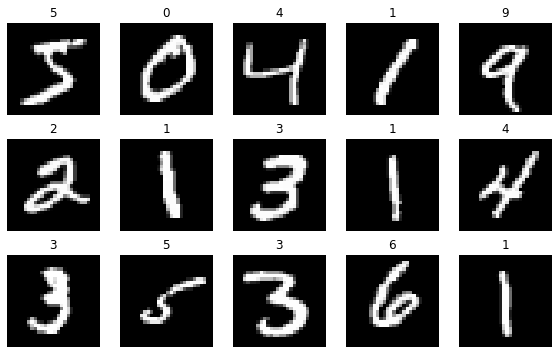

In [10]:
#데이터 시각화
import matplotlib.pyplot as plt

#canvas 생성
fig,axes = plt.subplots(3,5)
fig.set_size_inches(8,5)

for i in range(15):
    ax = axes[i//5,i%5]
    #imshow로 이미지 시각화
    ax.imshow(x_train[i],cmap='gray')
    ax.axis('off')
    ax.set_title(str(y_train[i]))

plt.tight_layout()
plt.show()

##3-2 데이터 전처리

In [11]:
#x_train 배열의 데이터 확인
x_train[0,10:15,10:15]  #배열의 각 원소는 이미지를 구성하는 하나의 픽셀 값과 일대일 매칭된다.

array([[  1, 154, 253,  90,   0],
       [  0, 139, 253, 190,   2],
       [  0,  11, 190, 253,  70],
       [  0,   0,  35, 241, 225],
       [  0,   0,   0,  81, 240]], dtype=uint8)

In [12]:
#픽셀 값의 최소/최대값 확인
print(f'정규화 전]최소값:{x_train.min()},최대값:{x_train.max()}')

#데이터 정규화
x_train = x_train/x_train.max()

#정규화 후 최소/최대값 확인
print(f'정규화 전] 최소값:{x_train.min()},최대값:{x_train.max()}')

정규화 전]최소값:0,최대값:255
정규화 전] 최소값:0.0,최대값:1.0


In [13]:
#test 셋에도 정규화 동일 적용
x_test = x_test / x_test.max()

In [14]:
#변환 후 x_train 배열의 데이터 확인
x_train[0,10:15,10:15]

array([[0.00392157, 0.60392157, 0.99215686, 0.35294118, 0.        ],
       [0.        , 0.54509804, 0.99215686, 0.74509804, 0.00784314],
       [0.        , 0.04313725, 0.74509804, 0.99215686, 0.2745098 ],
       [0.        , 0.        , 0.1372549 , 0.94509804, 0.88235294],
       [0.        , 0.        , 0.        , 0.31764706, 0.94117647]])

정규화하는 이유  
입력 데이터가 정규화되어 모델이 학습하는 경우 경사하강법 알고리즘에 의한 수렴 속도가 더 빠르고 , 국소 최적(local optimum)에 빠지는 현상을 방지해주는 효과가 있다.

##3-3 Flatten 레이어

In [15]:
print(f'변경 전 shape:{x_train.shape}')
print(f'1D으로 shape 변경 후:{x_train.reshape(60000,-1).shape}')

변경 전 shape:(60000, 28, 28)
1D으로 shape 변경 후:(60000, 784)


In [16]:
print(f'변경 전 shape:{x_train.shape}')
print(f'Flatten 적용 후:{tf.keras.layers.Flatten()(x_train).shape}')

변경 전 shape:(60000, 28, 28)
Flatten 적용 후:(60000, 784)


##3-4 활성화 함수

활성화 함수(Activation Function)는 입력을 비선형 출력으로 변환해주는 함수이다.

In [17]:
#Dense 레이어에 relu 활성화 함수를 적용한 경우
tf.keras.layers.Dense(128,activation='relu')

In [18]:
#Dense 레이어와 relu 활성화 함수 레이어를 별도 적용한 경우
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(128),
                             tf.keras.layers.Activation('relu')
])

##3-5 입력과 출력

분류 모델의 가장 마지막 레이어는 출력층  
출력층의 노드 개수는 반드시 분류해야 할 클래스의 개수와 동일해야 한다.

In [21]:
model = tf.keras.Sequential([
                             tf.keras.layers.Flatten(input_shape=(28,28)),
                             tf.keras.layers.Dense(256,activation='relu'),
                             tf.keras.layers.Dense(64,activation='relu'),
                             tf.keras.layers.Dense(32,activation='relu'),
                             #노드=10개(클래스 개수와 동일)
                             tf.keras.layers.Dense(10,activation='softmax')
])

모델의 깊이(레이어의 개수)와 너비(각 레이어를 구성하는 노드의 개수)에 대한 정답은 없다. 레이어 개수와 노드의 개수도 중요한 하이퍼파라미터가 된다.

In [22]:
#출력층 노드 = 1 인 경우, sigmoid
tf.keras.layers.Dense(1,activation='sigmoid')

#출력층 노드 = 2개 이상인 경우, softmax
#이진 분류 모델의 출력층 노드 개수를 1개로 설정한 경우에는 sigmoid 활성화 함수를 적용한다.
#단, 이진 분류 모델이더라도 출력 레이어의 클래스를 원핫 인코딩으로 변환하여 노드 개수가 2개인 경우에는 softmax 함수를 사용한다.
tf.keras.layers.Dense(10,activation='softmax')

##3-6 손실함수

분류 모델의 손실함수는 모델의 출력층에 따라 올바른 손실함수를 설정해야만 모델이 정상적으로 훈련할 수 있다.

In [23]:
#이진 분류(출력 노드 개수=1,sigmoid인 경우) = 마지막 출력층 Dense(1,acitvation='sigmoid')
model.compile(loss='binary_crossentropy')

In [25]:
#y가 원핫 벡터인 경우
#[0,0,0,1,0,0,0]
model.compile(loss='categorical_crossentropy')
#y가 원핫 벡터가 아닌 경우
#[5]
model.compile(loss='sparse_categorical_crossentropy')

##3-7 옵티마이저

옵티마이저(optimizer)는 손실을 낮추기 위해서, 신경망의 가중치와 학습률과 같은 신경망의 속성을 변경하는 데 사용되는 최적화 방법이다.

In [27]:
#클래스 인스턴스로 지정
adam = tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=adam)

#문자열로 지정
model.compile(optimizer='adam')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


##3-8 평가지표

In [28]:
#클래스 인스턴스로 지정
acc = tf.keras.metrics.SparseCategoricalAccuracy()

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=[acc])

In [30]:
#문자열로 지정
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

###3-9 훈련

In [31]:
#훈련
model.fit(x_train,y_train,
          #검증 셋 지정
          validation_data=(x_test,y_test),
          epochs=10)

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2238 - accuracy: 0.9330 - val_loss: 0.1134 - val_accuracy: 0.9657
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0949 - accuracy: 0.9709 - val_loss: 0.0919 - val_accuracy: 0.9715
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0665 - accuracy: 0.9793 - val_loss: 0.0829 - val_accuracy: 0.9744
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0492 - accuracy: 0.9844 - val_loss: 0.0876 - val_accuracy: 0.9757
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0399 - accuracy: 0.9878 - val_loss: 0.0895 - val_accuracy: 0.9756
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0341 - accuracy: 0.9889 - val_loss: 0.0817 - val_accuracy: 0.9775
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0281 - accuracy: 0.9910 - val_loss: 0.0931 - val_accuracy:

##3-10 평가

In [32]:
#검증
test_loss,test_acc = model.evaluate(x_test,y_test)

print('검증 셋 정확도:',test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.0903 - accuracy: 0.9787
검증 셋 정확도: 0.9786999821662903


##3-11 예측

In [33]:
#예측
predictions = model.predict(x_test)

In [34]:
#예측 결과 출력
predictions[0]   #10개의 개별 클래스에 대한 분류 확률값 / 이중 가장 높은 확률값을 가진 클래스가 최종 예측된 클래스

array([5.2139295e-12, 7.8441182e-08, 6.8850795e-08, 2.2138861e-08,
       1.6019635e-09, 5.5233539e-12, 1.8781905e-09, 9.9999940e-01,
       6.2061460e-11, 3.4389765e-07], dtype=float32)

In [35]:
import numpy as np

#0번 index에 대한 예측 클래스 출력
print(np.argmax(predictions[0]))

#첫 10개 index에 대한 예측 클래스 출력
print(np.argmax(predictions[:10],axis=1))

7
[7 2 1 0 4 1 4 9 5 9]


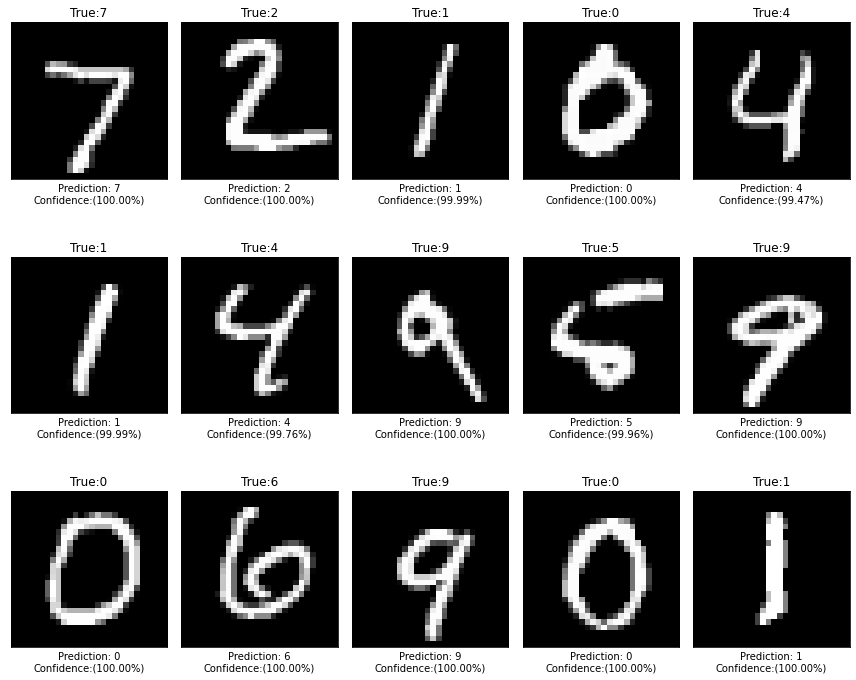

In [37]:
#데이터 시각화
import matplotlib.pyplot as plt
def get_one_result(idx):
    img,y_true,y_pred,confidence = x_test[idx],y_test[idx],np.argmax(predictions[idx]),100*np.max(predictions[idx])
    return img,y_true,y_pred,confidence

#canvas 생성
fig,axes = plt.subplots(3,5)
fig.set_size_inches(12,10)
for i in range(15):
    ax = axes[i//5,i%5]
    img,y_true,y_pred,confidence = get_one_result(i)
    #imshow로 이미지 시각화
    ax.imshow(img,cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'True:{y_true}')
    ax.set_xlabel(f'Prediction: {y_pred}\nConfidence:({confidence:.2f}%)')

plt.tight_layout()
plt.show()